In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import math
# import multiprocessing as mp
from  multiprocessing import Pool

In [2]:
#traces
traces = np.fromfile('traces_10000x50_int8.bin',dtype='int8')
traces = np.reshape(traces,(-1,50))
# traces.shape
#plaintext
plain_text = np.fromfile('plaintext_10000x16_uint8.bin',dtype='uint8')
plaintext_10000_16 = np.reshape(plain_text,(-1,16))


In [3]:
sbox = np.array([
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
])

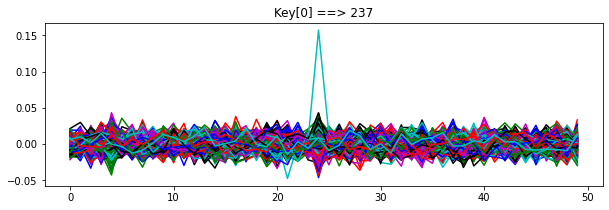

key 0 value 237


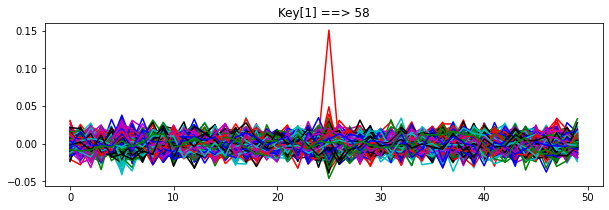

key 1 value 58


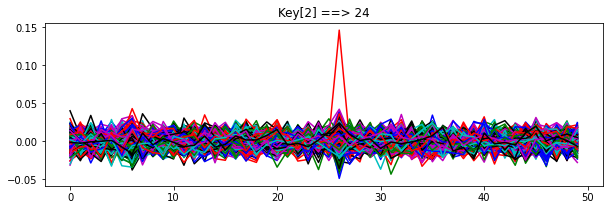

key 2 value 24


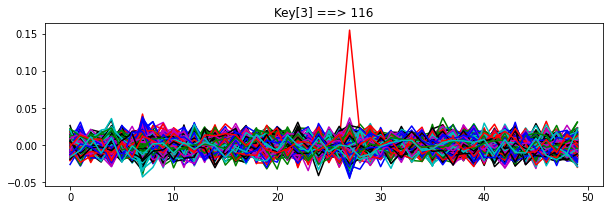

key 3 value 116


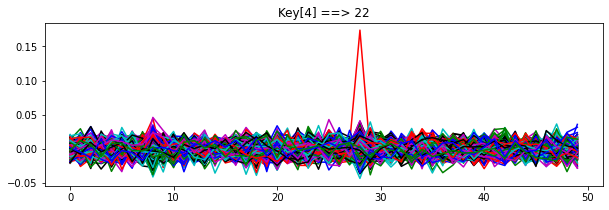

key 4 value 22


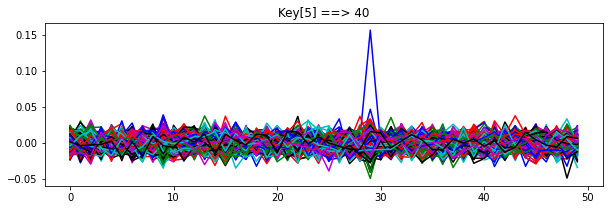

key 5 value 40


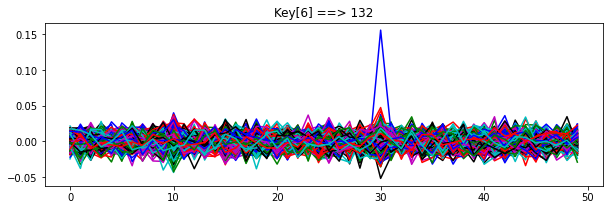

key 6 value 132


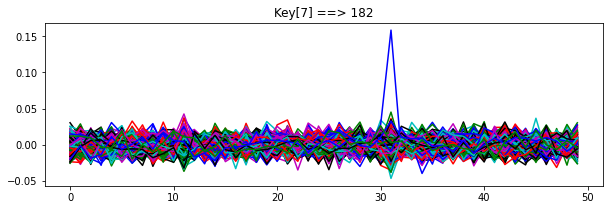

key 7 value 182


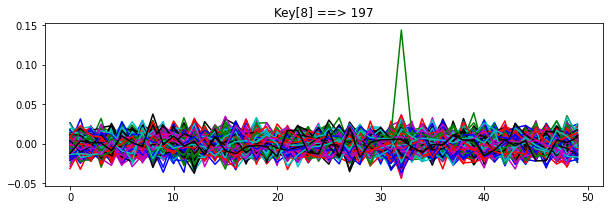

key 8 value 197


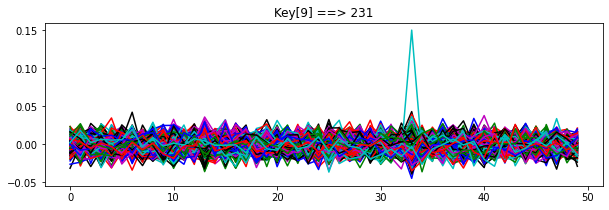

key 9 value 231


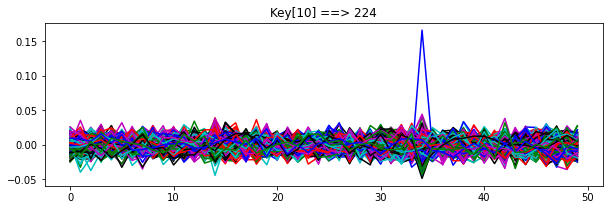

key 10 value 224


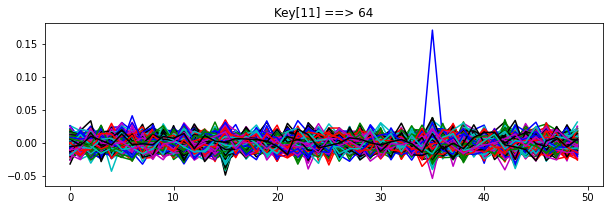

key 11 value 64


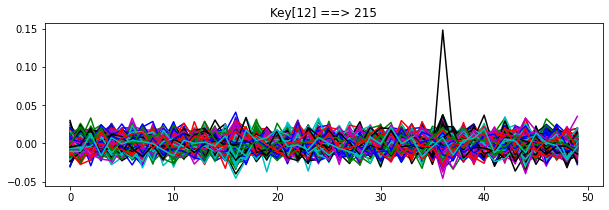

key 12 value 215


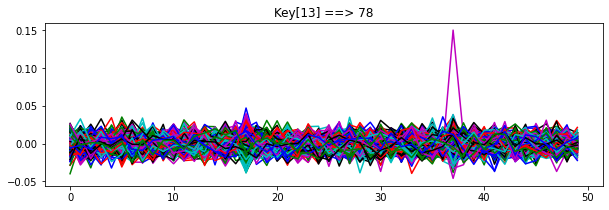

key 13 value 78


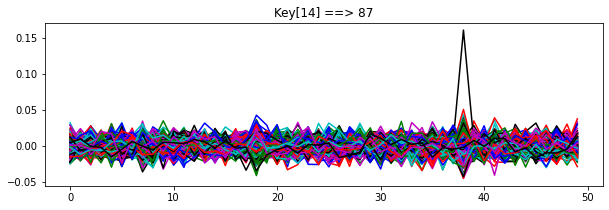

key 14 value 87


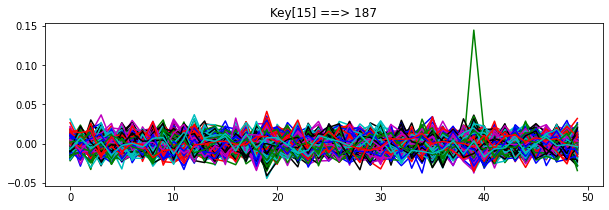

key 15 value 187
Total Time 63.00952458381653


In [5]:
from itertools import cycle
color = cycle('bgrcmk')

def find_key(byte):
    #key hypothesis vector 
    key_hypothesis = np.tile(np.arange(256), (10000, 1))
    #calculate traces mean along the columns
    traces_mean = np.mean(traces, axis = 0)

    d_vector = np.tile(plaintext_10000_16[:,i],(256,1))
    d_vector = d_vector.T #tranposing the datavector 
    # print(plaintext_10000_16[:,0])
    intermediate_value = np.array(
            sbox[np.bitwise_xor(d_vector, key_hypothesis)]
        ) #sbox look up

    # print(intermediate_value.shape)
    def count_ones(n):
            return (np.binary_repr(n)).count('1')
    # numpy.vectorize() to apply the function to each element in the array
    count_ones_vec = np.vectorize(count_ones)
    # Applying the function to each element in the intermediate_values
    hamming_values = count_ones_vec(intermediate_value)
    # print(hamming_values)
    hv_mean = np.mean(hamming_values, axis = 0)#hamming_values means

    #calculate the hammings
    h_vector = hamming_values - hv_mean#calulate the ham distance of HV
    t_vector = traces - traces_mean #calulate the ham distance of traces

    numerator = np.matmul(h_vector.T, t_vector) #calculating numerator

    h_vector_sq = np.sum(np.square(h_vector),axis = 0)#finding the square of h_vector
    t_vector_sq = np.sum(np.square(t_vector),axis = 0) #finding the square of t_vector

    denominator = np.sqrt(np.multiply.outer(h_vector_sq, t_vector_sq))#denominator calculation

    r = np.divide(numerator, denominator)#r matrix
    #plot graph
    _, ax = plt.subplots(figsize=(10, 3))
    x = np.array(range(50))
    plt.title(f"Key[{byte}] ==> {np.argmax(r)//50}")
    for key_guess in r:
        ax.plot(x,key_guess, c=next(color))
    plt.show()
    key = np.argmax(r)//50
    print("key",byte,"value",key)


# pooling multithreads 
# all_start = time()
# with Pool(16) as p:
#   p.map(find_key, range(16)) #pool processes for 16 bytes  
#   #Total execution time
#   print("Total Time", time()- all_start)

# #to run with single thread to get keys
all_start = time()
for i in range(16):
  find_key(i)
print("Total Time", time()- all_start)